# Проект по А/B-тестированию

***Задача*** 
Провести оценку результатов A/B-теста.

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- Оценить корректность проведения теста.
- Проанализировать результаты теста.

Чтобы оценить корректность проведения теста, проверить:
- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

***Техническое задание***
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
from numpy import median
import matplotlib.pyplot as plt
import seaborn as sns
#from plotly import graph_objects as go
import scipy.stats as stats
from scipy import stats as st
import math as mth

In [2]:
if os.path.exists('/datasets/ab_project_marketing_events.csv'):
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
else:
    marketing_events = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Выпускной проект/А_В_тестирование/ab_project_marketing_events.csv')
    new_users = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Выпускной проект/А_В_тестирование/final_ab_new_users.csv ')
    events = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Выпускной проект/А_В_тестирование/final_ab_events.csv')
    participants = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Выпускной проект/А_В_тестирование/final_ab_participants.csv')

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')
plt.rc('figure', figsize=(8, 5))

## Обзор данных.

In [5]:
display(marketing_events.head()) # посмотрим таблицу marketing_events
marketing_events.info()
display(round((marketing_events.isna().mean()*100),2)) # проверка на пропуски
display(marketing_events.duplicated().sum()) # проверим на дубликаты

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

0

In [6]:
display(new_users.head()) # посмотрим таблицу new_users
new_users.info()
display(round((new_users.isna().mean()*100),2)) # проверка на пропуски
display(new_users.duplicated().sum()) # проверим на дубликаты

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

0

In [7]:
display(events.head()) # посмотрим таблицу events
events.info()
display(round((events.isna().mean()*100),2)) # проверка на пропуски
display(events.duplicated().sum()) # проверим на дубликаты

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


user_id        0.00
event_dt       0.00
event_name     0.00
details       85.75
dtype: float64

0

In [8]:
display(participants.head()) # посмотрим таблицу participants
participants.info()
display(round((participants.isna().mean()*100),2)) # проверка на пропуски
display(participants.duplicated().sum()) # проверим на дубликаты

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

0

***Описание данных***

***marketing_events*** — календарь маркетинговых событий на 2020 год;

- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

***new_users*** — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

***events*** — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

***participants*** — таблица участников тестов.

- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

Первичный просмотр данных показал, что:

- Все четыре таблицы не имеют дубликатов значений. 
- Пропуски есть только в таблице events в столбце details. 
- В таблицах marketing_events, new_users и events есть даты, нужно привести их к соответствующему типу. 
- Стоит привести к нижнему регистру все содержимое столбцов.

## Подготовка и приведение данных к нужным типам.

In [9]:
# посмотрим для каких событий нет дополнительных данных
events[events.isna().any(axis=1)]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [10]:
# приведём к нужному типу данные таблицы marketing_events
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [11]:
# приведём к нужному типу данные таблицы new_users
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [12]:
# приведём к нужному типу данные таблицы events
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [13]:
# все строковые значения всех таблиц приведём к нижнему регистру
marketing_events = marketing_events.apply(lambda x: x.astype(str).str.lower() if(x.dtype == 'object') else x)
#marketing_events
new_users = new_users.apply(lambda x: x.astype(str).str.lower() if (x.dtype == 'object') else x)
#new_users
events = events.apply(lambda x: x.astype(str).str.lower() if (x.dtype == 'object') else x)
#events
participants = participants.apply(lambda x: x.astype(str).str.lower() if (x.dtype == 'object') else x)
#participants

***Вывод по подготовке данных***

В таблице events есть пропуски в столбце details. Этот столбец содержит дополнительные данные о событии(столбец event_name). Выяснилось, что дополнительных данных нет для событий: 'product_cart', 'product_page', 'login', что вполне логично, поэтому оставляем всё как есть.

Так же в этом шаге привели данные по датам к нужному типу и все строковые значения всех таблиц к нижнему регистру.

# Оценка корректности проведения А/В-теста.

## Соответствие данных требованиям технического задания. 

In [14]:
# сформируем объединённый датасет по тесту "recommender_system_test"
#data = participants.merge(new_users, on='user_id', how='left').merge(events, on='user_id', how='inner')
data = participants.merge(new_users, on='user_id', how='left').merge(events, on='user_id', how='left')

data = data.query('ab_test == "recommender_system_test"').drop('ab_test', axis=1)
# добавим столбец с датой события 
data['event_date'] = data['event_dt'].dt.date
data.head()
#data.info()

,user_id,group,first_date,region,device,event_dt,event_name,details,event_date
0,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [15]:
#data['user_id'].nunique()

In [16]:
# проверим на наличие пользователей в нескольких группах
users_dou = data.groupby('user_id')['group'].nunique()
orders_dou = pd.DataFrame(data['user_id']).merge(users_dou, on="user_id")
#orders_dou.head(50)
print('Количество пользователей в нескольких группах', len(orders_dou.query('group >1')))

Количество пользователей в нескольких группах 0


In [17]:
# сколько у нас групп в АВ-тесте
print('Групп пользователей в тесте', data['group'].nunique(), data['group'].unique())

Групп пользователей в тесте 2 ['a' 'b']


In [18]:
print('Дата начала регистрации пользователей: ', data['first_date'].min())
print('Дата окончания регистрации пользователей: ', data['first_date'].max())

Дата начала регистрации пользователей:  2020-12-07 00:00:00
Дата окончания регистрации пользователей:  2020-12-21 00:00:00


In [19]:
print('Дата остановки теста: ', data['event_dt'].max())
print('Количество участников теста: ', data['user_id'].nunique())

Дата остановки теста:  2020-12-30 12:42:57
Количество участников теста:  6701


In [20]:
# оставим в тесте пользователе региона EU(согласно ТЗ)
data = data.query('region == "eu"')
print('Количество участников теста стало: ',data['user_id'].nunique())

Количество участников теста стало:  6351


In [21]:
print('Количество участников в контрольной группе A: ', data.query('group == "a"')['user_id'].nunique())
print('Количество участников в тестовой группе B: ', data.query('group == "b"')['user_id'].nunique())

Количество участников в контрольной группе A:  3634
Количество участников в тестовой группе B:  2717


In [22]:
# количество новых пользователей учавствующих в тетсте из EU 
count_user_eu_test = data.query('region == "eu" & first_date <= "2020-12-21"')['user_id'].nunique()
count_user_eu_test
count_user_eu = new_users.query('region == "eu" & first_date <= "2020-12-21" ')['user_id'].nunique()
# доля новых пользователей из EU учавствующих в тетсте
ratio = round((count_user_eu_test / count_user_eu * 100), 2)
print('В тесте "recommender_system_test" учавствует {} % новых пользователей из EU'.format(ratio))

В тесте "recommender_system_test" учавствует 15.0 % новых пользователей из EU


Соответствует техническому заданию:

- Групп в тесте 2 ['a' 'b']
- Дата начала регистрации пользователей:  2020-12-07 00:00:00
- Дата окончания регистрации пользователей:  2020-12-21 00:00:00

Есть расхождения с условиями ТЗ:

- Дата остановки теста:  2020-12-30 12:42:57 (по заданию тетст должен быть остановлен 2021-01-04)
- Количество участникоыв теста:  6351 (Ожидаемое количество участников теста: 6000.)
- Новых пользователей из EU: 15 % (Аудитория: 15% новых пользователей из региона EU)

Пользователи в соответствие с заданием были распределены на две группы, даты начала и окончания регистрации выдержаны. Возможно остановка работы теста раньше предесмотренной в ТЗ датой связана с технической проблемой. 

Ещё хочется отметить не равномерное распределение участников в группы. В контрольную группу попало почти 57% пользоватлей, учавствующих в "recommender_system_test".

## Равномерность распределения пользователей по тестовым группам и правильность их формирования.

### Проверим данные на наличие пользователей в двух тестах

In [23]:
print('Названия тестов{}'.format(participants['ab_test'].unique()))
# проверим на наличие пользователей в двух тестах
users_dou = pd.DataFrame(participants.groupby('user_id')['ab_test'].nunique()).reset_index().query('ab_test > 1')
print('В оба тетста попало {} пользователя.'.format(users_dou['user_id'].nunique()))

Названия тестов['recommender_system_test' 'interface_eu_test']
В оба тетста попало 1602 пользователя.


In [24]:
# найдём пользователей которые учавствовали 'в' группе и теста "interface_eu_test"
list_user_dou = users_dou['user_id']
#list_user_dou
participants_duo = participants.query('user_id in @list_user_dou & group == "b" & ab_test == "interface_eu_test"')
participants_duo

,user_id,group,ab_test
6705,2ba8fa8754d1fe50,b,interface_eu_test
6706,fb6f6bc119e1dbd5,b,interface_eu_test
6725,7060bb1cbe3baacc,b,interface_eu_test
6727,97248d21983c5dbc,b,interface_eu_test
6738,8e69896f59a3b8f8,b,interface_eu_test
...,...,...,...
18130,02313b9e82255f47,b,interface_eu_test
18161,6442d23d6e0b3a56,b,interface_eu_test
18170,7df21aeb1aa231f9,b,interface_eu_test
18183,ea6ea431ff84563b,b,interface_eu_test


In [25]:
list_user_drop = list(participants_duo['user_id']) # список пользователей учавстующих в тестовой группе interface_eu_test
#len(list_user_drop)

In [26]:
print('Количество пользователей, попавших в группу а теста "recommender_system_test"', participants.query('user_id in @list_user_drop & ab_test == "recommender_system_test" & group == "a"')['user_id'].nunique())
print('Количество пользователей, попавших в группу b теста "recommender_system_test"', participants.query('user_id in @list_user_drop & ab_test == "recommender_system_test" & group == "b"')['user_id'].nunique())

Количество пользователей, попавших в группу а теста "recommender_system_test" 439
Количество пользователей, попавших в группу b теста "recommender_system_test" 344


In [27]:
# удалим пользователей, которые учавствуют во втором тесте в группе 'в
participants = participants.query('user_id not in @list_user_drop & ab_test == "recommender_system_test"')
participants['user_id'].nunique()
#participants

5918

При проверке на участие пользователей в двух тетстах - таких выявлено 1602. Так как у нас нет информации о втором тесте, и распределение пользователей в нашем тесте между контрольной и тестовой группой не равномерно стоит их удалить. После чего в тетсте осталось 5918 участников.

### Разделим участников теста на группы и посмотрим на них.

In [28]:
# посмотрим на группы по отдельности.
group_a = data.query('group == "a"')
group_b = data.query('group == "b"')
display(group_a.head(), group_b.head())

,user_id,group,first_date,region,device,event_dt,event_name,details,event_date
0,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,product_page,NaN,2020-12-07


,user_id,group,first_date,region,device,event_dt,event_name,details,event_date
32,482f14783456d21b,b,2020-12-14,eu,pc,NaT,NaN,NaN,NaT
59,057ab296296c7fc0,b,2020-12-17,eu,iphone,NaT,NaN,NaN,NaT
66,e9fa12fae3f5769c,b,2020-12-14,eu,android,NaT,NaN,NaN,NaT
74,cd74c3d22ffc09c2,b,2020-12-21,eu,android,2020-12-21 14:10:54,product_page,NaN,2020-12-21
75,cd74c3d22ffc09c2,b,2020-12-21,eu,android,2020-12-22 11:22:05,product_page,NaN,2020-12-22


In [29]:
print('Доля контрольной группы a: {}% от общего числа участников.'.format(round(data.query('group == "a"')['user_id'].nunique()/data['user_id'].nunique() * 100)))
print('Доля тестовой группы b: {}% от общего числа участников.'.format(round(data.query('group == "b"')['user_id'].nunique()/data['user_id'].nunique() * 100)))

Доля контрольной группы a: 57% от общего числа участников.
Доля тестовой группы b: 43% от общего числа участников.


In [30]:
# из каких регионов и с каких устройст заходили на сайт участники группы.
df_group = data.pivot_table(index=['region', 'group', 'device', 'first_date'], values='user_id', aggfunc='nunique').reset_index().sort_values(by='user_id', ascending=False)

df_group.head()

,region,group,device,first_date,user_id
14,eu,a,android,2020-12-21,185
7,eu,a,android,2020-12-14,161
0,eu,a,android,2020-12-07,149
6,eu,a,android,2020-12-13,142
74,eu,b,android,2020-12-21,140


In [31]:
#df_group_a = df_group.query('group == "a"')
#df_group_a
#df_a = df_group_a.pivot_table(index='region', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
#df_a['ratio'] = round((df_a['user_id'] / df_group_a['user_id'].sum() *100))
#print('Распределение пользователей по регионам в контрольной группе.')
#display(df_a)

#df_group_b = df_group.query('group == "b"')
#df_group_a
#df_b = df_group_b.pivot_table(index='region', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
#df_b['ratio'] = round((df_b['user_id'] / df_group_b['user_id'].sum() *100))
#print('Распределение пользователей по регионам в тестовой группе.')
#display(df_b)

In [32]:
df_group_a = df_group.query('group == "a"')
df_a = df_group_a.pivot_table(index='device', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
df_a['ratio'] = round((df_a['user_id'] / df_group_a['user_id'].sum() *100))
print('Распределение пользователей по устройствам в контрольной группе.')
display(df_a)

df_group_b = df_group.query('group == "b"')
df_b = df_group_b.pivot_table(index='device', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
df_b['ratio'] = round((df_b['user_id'] / df_group_b['user_id'].sum() *100))
print('Распределение пользователей по устройствам в тестовой группе.')
display(df_b)



Распределение пользователей по устройствам в контрольной группе.


,device,user_id,ratio
0,android,1590,44.0
3,pc,964,27.0
1,iphone,726,20.0
2,mac,354,10.0


Распределение пользователей по устройствам в тестовой группе.


,device,user_id,ratio
0,android,1228,45.0
3,pc,657,24.0
1,iphone,582,21.0
2,mac,250,9.0


In [33]:
df_a = df_group_a.pivot_table(index='first_date', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
df_a['ratio'] = round((df_a['user_id'] / df_group_a['user_id'].sum() *100))
print('Распределение пользователей по дате регистрации в контрольной группе.')
display(df_a)

df_b = df_group_b.pivot_table(index='first_date', values='user_id', aggfunc='sum').reset_index().sort_values('user_id', ascending=False)
df_b['ratio'] = round((df_b['user_id'] / df_group_b['user_id'].sum() *100))
print('Распределение пользователей по дате регистрации в тестовой группе.')
display(df_b)

#(fig, ax) = plt.subplots(figsize=(20,5))
#ax.plot(x=df_a['first_date'], y=df_a['user_id'], 'o-', color='orange')
#ax.plot(x=df_b['first_date'], y=df_b['user_id'], 'o-', color='green')
#plt.show()

Распределение пользователей по дате регистрации в контрольной группе.


,first_date,user_id,ratio
14,2020-12-21,398,11.0
7,2020-12-14,366,10.0
0,2020-12-07,349,10.0
6,2020-12-13,323,9.0
5,2020-12-12,268,7.0
13,2020-12-20,255,7.0
12,2020-12-19,226,6.0
11,2020-12-18,210,6.0
8,2020-12-15,202,6.0
10,2020-12-17,202,6.0


Распределение пользователей по дате регистрации в тестовой группе.


,first_date,user_id,ratio
14,2020-12-21,285,10.0
7,2020-12-14,262,10.0
0,2020-12-07,259,10.0
6,2020-12-13,228,8.0
13,2020-12-20,206,8.0
5,2020-12-12,198,7.0
3,2020-12-10,181,7.0
12,2020-12-19,173,6.0
11,2020-12-18,172,6.0
1,2020-12-08,149,5.0


По количеству участников группы сформированы не равноммерно 57% от общего числа участников входит в контрольную группу - это достаточно большой перекос.

Что касается правильности формирования, то пропорционально группы сформированы одинаково. Доли участников в обоих группах по устройствам и датам регистрации по большей части одинаковы.

## Время проведения теста и маркетинговые активности.

In [34]:
# какие маркетинговые акции проводились и где
marketing_events_rst = marketing_events.query('start_dt >= "2020-12-07"')
marketing_events_rst

,name,regions,start_dt,finish_dt
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
10,cis new year gift lottery,cis,2020-12-30,2021-01-07


In [35]:
data

,user_id,group,first_date,region,device,event_dt,event_name,details,event_date
0,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,d1aba3e2887b6a73,a,2020-12-07,eu,pc,2020-12-07 14:43:27,product_page,NaN,2020-12-07
...,...,...,...,...,...,...,...,...,...
26285,80712ed4ea1b52a5,a,2020-12-14,eu,android,2020-12-15 20:10:06,product_page,NaN,2020-12-15
26286,80712ed4ea1b52a5,a,2020-12-14,eu,android,2020-12-20 20:01:34,product_page,NaN,2020-12-20
26287,80712ed4ea1b52a5,a,2020-12-14,eu,android,2020-12-14 05:48:50,login,NaN,2020-12-14
26288,80712ed4ea1b52a5,a,2020-12-14,eu,android,2020-12-15 20:10:03,login,NaN,2020-12-15


### Влияние "christmas&new year promo" на пользователей из Европы.

<AxesSubplot:xlabel='event_date'>

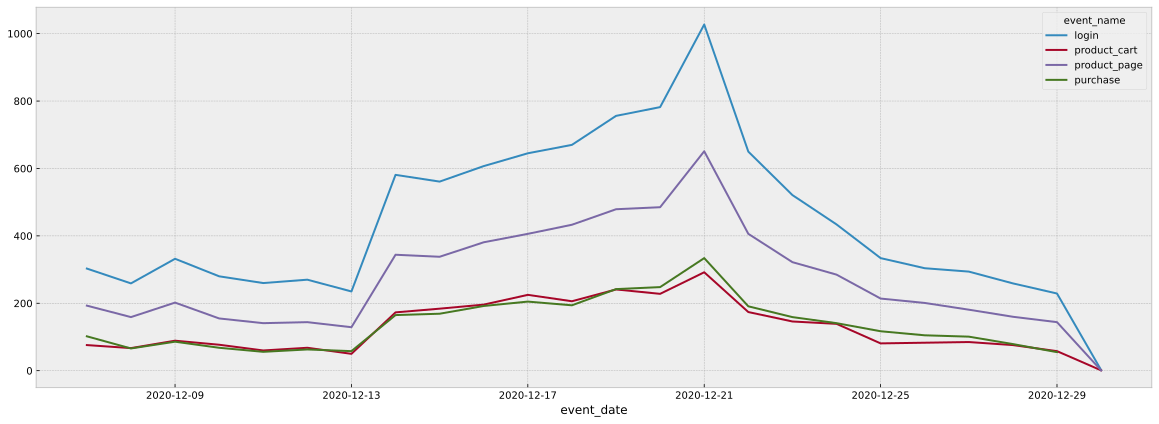

In [36]:
# влияние christmas&new year promo
# посчитаем количество событий по дате для пользователей из Европы и Северной Америки
df = data.query('region != "cis"').pivot_table(index='event_date', columns='event_name', values=['user_id'], aggfunc='count').reset_index()
df.plot(x='event_date', y='user_id', kind='line', grid=True, figsize=(20, 7))

Акция "christmas&new year promo"	проводилась для покупателей из Европы и Северной Амрики с 2020-12-25 по 2021-01-03.

На графике наглядно видно, что никакого заметного влияния на поведение наших пользователей эта активность не оказала. Скорее можно сказать, что не только заходы на сайт, но и покупки активизировались в период с 13 по 21 декабря и вероятно это связано с покупкой подарков на Рождество.

In [37]:
#df = data.query('region == "cis"').pivot_table(index='event_date', columns='event_name', values=['user_id'], aggfunc='count').reset_index()
#df.plot(x='event_date', y='user_id', kind='line', grid=True, figsize=(20, 7))

Для покупателей из СНГ проводилась лотерея "cis new year gift lottery"	с 2020-12-30 по 2021-01-07.

Возможно о лотерее было объявлено заранее и событие "login" связано именно с этой акцией, но эти покупателеи в основной своей массе не пошли дальше  "product_cart". 

***Вывод***

Оценив влияние маркетинговых мероприятий проводимых в момомент тестирования, можно сказать, что они существенного действия не оказали.

# Исследовательский анализ данных.

##  Количество событий на пользователя одинаково распределены в выборках?

In [38]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   first_date  26290 non-null  datetime64[ns]
 3   region      26290 non-null  object        
 4   device      26290 non-null  object        
 5   event_dt    23420 non-null  datetime64[ns]
 6   event_name  23420 non-null  object        
 7   details     3196 non-null   float64       
 8   event_date  23420 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.0+ MB


In [39]:
# удалим данные по пользователям, которые не совершали действий после регистрации
data.dropna(subset=['event_name'], inplace=True)

print('Количество пользователей совершивших хотя бы одно событие:', data['user_id'].nunique())
#data.info()

Количество пользователей совершивших хотя бы одно событие: 3481


In [40]:
# посчитаем количество событий по каждой группе
df = (data.pivot_table(index=['event_name', 'group'], values='user_id', aggfunc='count')
      .reset_index()
      .rename({'user_id': 'event_count'}, axis=1)
      .sort_values(by='event_name')
     )
df_event_a = df.query('group == "a"')
df_event_b = df.query('group == "b"')

display(df_event_a, df_event_b)

#sns.set(rc={'figure.figsize':(15,5)})
#sns.barplot(data=df, x='event_count', y='event_name', hue='group', palette="Blues_d")
#plt.title('Количество событий по группам.')
#plt.xlabel('Событие.')
#plt.ylabel('Количество.')
#plt.show()

,event_name,group,event_count
0,login,a,8124
2,product_cart,a,2422
4,product_page,a,5227
6,purchase,a,2536


,event_name,group,event_count
1,login,b,2471
3,product_cart,b,653
5,product_page,b,1327
7,purchase,b,660


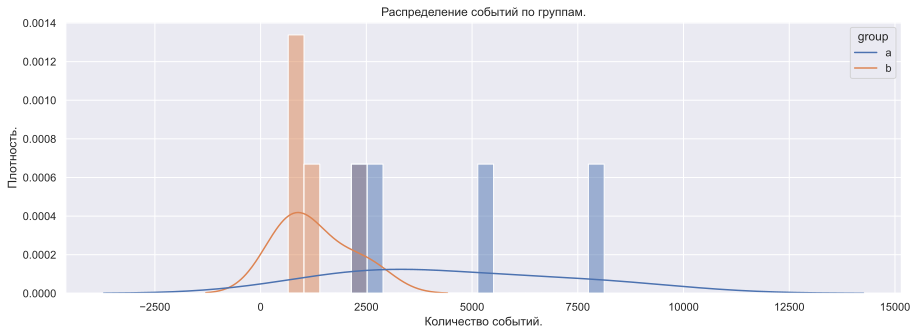

In [41]:
# посмотрим распределение на графике
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(data=df, x='event_count', hue='group', bins=20, stat='density', common_norm=False)
sns.kdeplot(x='event_count', data=df, hue='group', common_norm=False);
plt.title("Histogram")
plt.title('Распределение событий по группам.')
plt.xlabel('Количество событий.')
plt.ylabel('Плотность.')
plt.show();

In [42]:
# среденее количество событий для пользователей контрольной группы
mean_event_a = (group_a
                .pivot_table(index=['user_id', 'event_name'], values=('event_dt'), aggfunc='count')
                .reset_index()
                .groupby(by='event_name')
                .agg({'event_dt': 'mean'})
                .reset_index()
                .round(2)
               )
mean_event_a

,event_name,event_dt
0,login,3.12
1,product_cart,3.10
2,product_page,3.10
3,purchase,3.04


In [43]:
# среденее количество событий для пользователей тестовой группы
mean_event_b = (group_b
                .pivot_table(index=['user_id', 'event_name'], values=('event_dt'), aggfunc='count')
                .reset_index()
                .groupby(by='event_name')
                .agg({'event_dt': 'mean'})
                .reset_index()
                .round(2)
               )
mean_event_b

,event_name,event_dt
0,login,2.82
1,product_cart,2.68
2,product_page,2.69
3,purchase,2.65


Среднее количество событий совершённое пользователями в контрольной группе выше, чем в тетстовой. Количество событий на пользователя по разному распределены в выборках. Плотность рапределения выше у тетстовой группы.

## Как число событий в выборках распределено по дням?

In [44]:
# посчитаем количество событий по каждой группе
df = (data.pivot_table(index=['event_name', 'group', 'event_date'], values='user_id', aggfunc='count')
      .reset_index()
      .rename({'user_id': 'event_count'}, axis=1)
      .sort_values(by='event_date')
     )
df
df_event_a = df.query('group == "a"')
df_event_b = df.query('group == "b"')

display(df_event_a, df_event_b)

,event_name,group,event_date,event_count
0,login,a,2020-12-07,148
47,product_cart,a,2020-12-07,35
141,purchase,a,2020-12-07,43
94,product_page,a,2020-12-07,92
1,login,a,2020-12-08,146
...,...,...,...,...
68,product_cart,a,2020-12-28,70
116,product_page,a,2020-12-29,125
69,product_cart,a,2020-12-29,52
22,login,a,2020-12-29,193


,event_name,group,event_date,event_count
70,product_cart,b,2020-12-07,41
117,product_page,b,2020-12-07,101
23,login,b,2020-12-07,155
164,purchase,b,2020-12-07,59
118,product_page,b,2020-12-08,61
...,...,...,...,...
92,product_cart,b,2020-12-29,6
45,login,b,2020-12-29,36
140,product_page,b,2020-12-30,1
46,login,b,2020-12-30,2


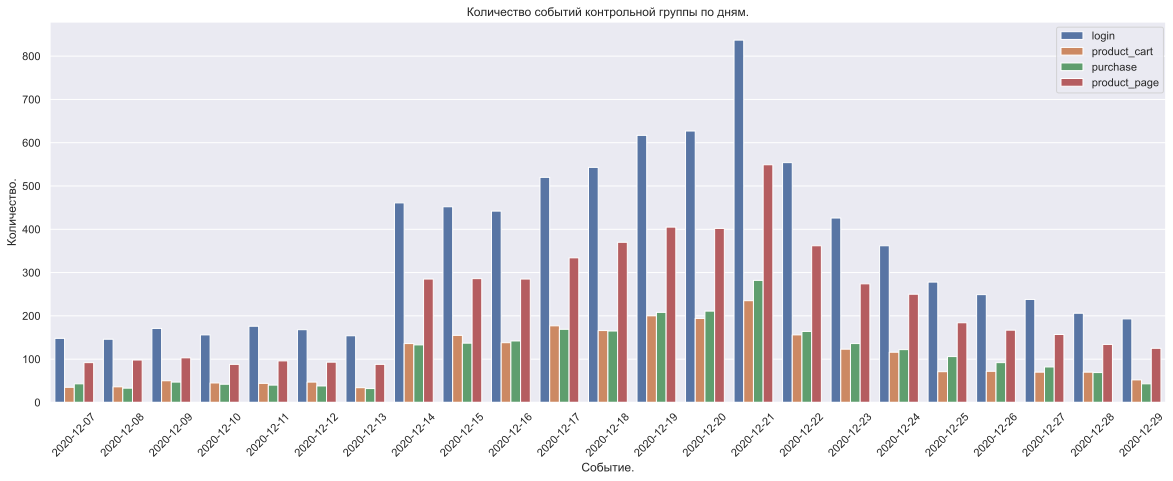

In [45]:
sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(data=df_event_a, y='event_count', x='event_date', hue='event_name')
plt.title('Количество событий контрольной группы по дням.')
plt.xlabel('Событие.')
plt.ylabel('Количество.')
plt.legend(loc='center', bbox_to_anchor=(0.95, 0.9), ncol=1)
plt.xticks(rotation=45)
plt.show()

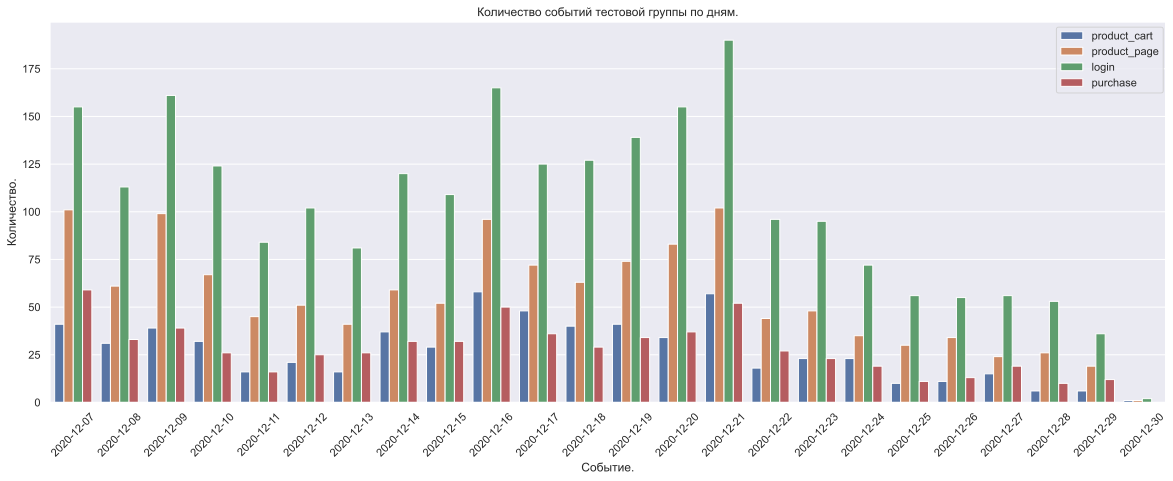

In [46]:
sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(data=df_event_b, y='event_count', x='event_date', hue='event_name')
plt.title('Количество событий тестовой группы по дням.')
plt.xlabel('Событие.')
plt.ylabel('Количество.')
plt.legend(loc='center', bbox_to_anchor=(0.95, 0.9), ncol=1)
plt.xticks(rotation=45)
plt.show()

Обе группы показывают наибольшую активность 21-12-2020 - в последний день регистрации покупателей в группы.
Тридцатого числа только по тестовой группы есть события. В обоих группах можно отметить в некоторые дни количество покупок(purchase) превышает число показов корзины(product_cart) - из чего следует, что оплатить покупку можно не заходя в корзину. 

## Как меняется конверсия в воронке в выборках на разных этапах?

In [47]:
df = (df.pivot_table(index=['event_name', 'group'], values='event_count', aggfunc='sum')
      .reset_index()
      .sort_values(by='event_count', ascending=False))
df

,event_name,group,event_count
0,login,a,8124
4,product_page,a,5227
6,purchase,a,2536
1,login,b,2471
2,product_cart,a,2422
5,product_page,b,1327
7,purchase,b,660
3,product_cart,b,653


In [48]:
fig = go.Figure() # построим воронку с разбивкой по группам

fig.add_trace(go.Funnel(
    name = 'a',
    y=df.query('group == "a"')['event_name'],
    x=df.query('group == "a"')['event_count'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'b',
    y=df.query('group == "b"')['event_name'],
    x=df.query('group == "b"')['event_count'],
    textposition = "inside",
    textinfo = "value+percent initial"))


fig.show()

NameError: name 'go' is not defined

In [ ]:
conv_a = df.query('event_name == "purchase" & group == "a"').iloc[0]['event_count']/df.query('event_name == "login" & group == "a"').iloc[0]['event_count']*100
conv_b = df.query('event_name == "purchase" & group == "b"').iloc[0]['event_count']/df.query('event_name == "login" & group == "b"').iloc[0]['event_count']*100
print('Конверсия в группе а из зашедших на сайт в покупку составляет: {:.2f}%'.format(conv_a))
print('Конверсия в группе b из зашедших на сайт в покупку составляет: {:.2f}%'.format(conv_b))
print('Отношение конверсии в покупки в группе В к группе А: {:.2f}%'.format(conv_b / conv_a * 100))

Конверсию считаем отностительно шага login:

- Конверсия в просмотр карточек товаров для контрольной группы составила 64%, для тетстовой только 54%.
- Конверсия в просмотры корзины для контрольной группы составила 30%, для тетстовой только 26%.
- Конверсия в покупку для контрольной группы составила 31%, тогда как для тетстовой только 27%. 

Больше всего пользователей теряется на переходе от шага login в шаг product_page: для контрольной группы это 36%, а для тестовой 46% пользователей. Возможно есть технические проблемы при переходе на страницу товара.

Уже сейчас можно говорить, что цель "Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%" не была достигнута. Действия по созданию новой платёжной воронки принесли отрицательный эффект - конверсии в покупки в группе В меньше, чем в группе А почти на 15%.

## Когда и с каких устройств пользователи заходили на сайт и останавливались на шаге login.

In [ ]:
# данные о пользователеях не прошедших дальше шага login 
df_login = (data.query('event_name != "purchase" & event_name != "product_page" & event_name != "product_cart"')
 .pivot_table(index=['device', 'event_date'], values='user_id', aggfunc='nunique')
 .reset_index()
 .rename({'user_id': 'count_users'}, axis=1)
)
df_login

In [ ]:
(df_login.pivot_table(index='event_date', values='count_users', aggfunc='sum').reset_index().plot(x='event_date', kind='bar'))
plt.title('Количество пользователей не прошедших дальше login по дате.')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.show()

In [ ]:
(df_login.pivot_table(index='device', values='count_users', aggfunc='sum').reset_index().sort_values(by='count_users', ascending=False).plot(x='device', kind='bar'))
plt.title('Количество пользователей не прошедших дальше login по типу устройства.')
plt.xticks(rotation=45)
plt.xlabel('Тип устройства.')
plt.show()

Больше всего пользователей не смогли пройти дальше просмотра страницы login 21 декабря когда на сайте наблюдалась наибольшая активность покупателей, что касается типа устройств то хуже всего дела обстоят у пользователей с android.

# Оценка результатов A/B-тестирования.

## Проверить статистическую разницу долей z-критерием.

In [ ]:
# подготовим данные для тестирования
data_exp = (data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
     ).reset_index()#.reset_index()
# не будем считать долю пользователей, которые не добрались до шага log, а только согласно ТЗ
# конверсии в просмотр карточек товаров — событие product_page, просмотры корзины — product_cart и покупки — purchase.

data_exp = data_exp.drop(data_exp.index[0]).reset_index()
data_exp

In [ ]:
# всего участников после всех фильтраций по группам
exp_users = data.groupby('group')['user_id'].nunique()
exp_users
print('Количество событий участников теста в группе а:', exp_users[0])
print('Количество событий участников теста в группе b:', exp_users[1])

In [ ]:
exp_id_list = data_exp.columns.values[2:] # названия групп
exp_id_list

***Сформулируем нулевую и альтернативную гипотезы:***

Нулевая гипотеза H₀: Доли пользователей совершившие каждое событие в a (контрольной) и b (с новой платёжной воронкой) группах одинаковые.
Альтернативная гипотеза H₁: Доли пользователей совершившие каждое событие в a (контрольной) и b (с новой платёжной воронкой) группах разные.

In [ ]:
# Ранее мы выяснили, что проход по всем этапам воронки не является обязательным.
# работать нужно относительно числа клиентов в шаге login.

def z_value_st (exp_a, exp_b, exp_users_a, exp_users_b, alpha):
    
    for i in data_exp.index:
        alpha = alpha
        successes = np.array([data_exp[exp_a][i], data_exp[exp_b][i]])
        trials = np.array([exp_users_a, exp_users_b])
        counter = len(data_exp)
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Событие {} '.format(data_exp['event_name'][i]))
        print('p-значение:', round((p_value), 5))
        
        # поправка Бонферрони
        bonferroni_alpha = alpha / counter
        
        if p_value < bonferroni_alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
            ) 
        print()

In [ ]:
# вызовем функцию
z_value_st (exp_id_list[0], exp_id_list[1], exp_users[0], exp_users[1], 0.05)

Сравнив с помощью z-тетста доли клиентов совершавших каждое событие в контрольной и тестовых группах, получилось выявить статистически значимое различие в конверсии только в просмотр карточек товаров — событие product_page, по остальным шагам воронки нет оснований считать доли разными. Критический уровень статистической значимости принимали 5%.

# Выводы и рекомендации.

Согласно ТЗ цель тетста подтвердить ожидаемый эффект от новой платёжной воронки: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%". 

Цель не была достигнута. Действия по созданию новой платёжной воронки принесли отрицательный эффект - конверсии в покупки в группе В меньше, чем в группе А почти на 15%. 

Для оценки результатов A/B-теста нам были предоставлены данные и ТЗ.

В ходе исследования данных выяснилось, что:
- сответствует техническому заданию и является корректным:

- Групп в тесте 2 ['a' 'b']
- Дата начала регистрации пользователей:  2020-12-07 00:00:00
- Дата окончания регистрации пользователей:  2020-12-21 00:00:00
- Пропорционально группы сформированы одинаково. Доли участников в обоих группах по устройствам и датам регистрации по большей части одинаковы.

- есть расхождения с условиями ТЗ:

- Дата остановки теста:  2020-12-30 12:42:57 (по заданию тетст должен быть остановлен 2021-01-04)
- Количество участникоыв теста:  6351 (Ожидаемое количество участников теста: 6000.)
- Новых пользователей из EU: 15 % (Аудитория: 15% новых пользователей из региона EU)
- При проверке на участие пользователей в двух тетстах - таких выявлено 1602. Так как у нас нет информации о втором тесте, и распределение пользователей в нашем тесте между контрольной и тестовой группой этих пользователей не равномерно удаляем их. После чего в тетсте осталось 5918 участников.
- Не равномерное распределение участников в группы. В контрольную группу попало почти 57% пользоватлей, учавствующих в "recommender_system_test" -это достаточно большой перекос.
- Среднее количество событий совершённое пользователями в контрольной группе выше, чем в тетстовой. Количество событий на пользователя по разному распределены в выборках. Плотность рапределения выше у тетстовой группы.

Во время проведения теста проходили маркетинговые мероприятия, оценив их влияние, можно сказать, что они существенного действия не оказали, так как тест проводился в Европе в преддверии Рождества.

Хочется так же отметить:

- Обе группы показывают наибольшую активность 21-12-2020 - в последний день регистрации покупателей в группы.
- Тридцатого числа только по тестовой группы есть события. 
- В обоих группах можно отметить в некоторые дни количество покупок(purchase) превышает число показов корзины(product_cart) - из чего следует, что оплатить покупку можно не заходя в корзину. 
- Похоже, что остановка работы теста раньше предесмотренной в ТЗ датой связана с технической проблемой. 


Построив воронку событий соит отметить:

- Конверсия в просмотр карточек товаров для контрольной группы составила 64%, для тетстовой только 54%.
- Конверсия в просмотры корзины для контрольной группы составила 30%, для тетстовой только 26%.
- Конверсия в покупку для контрольной группы составила 31%, тогда как для тетстовой только 27%.
Конверсию считали отностительно шага login.

Больше всего пользователей теряется на переходе от шага login в шаг product_page: для контрольной группы это 36%, а для тестовой 46% пользователей. Возможно есть технические проблемы при переходе на страницу товара. Больше всего пользователей не прошли дальше просмотра страницы login 21 декабря когда на сайте наблюдалась наибольшая активность покупателей, что касается типа устройств то хуже всего дела обстоят у пользователей с android.

Сравнив с помощью z-тетста доли клиентов совершавших каждое событие в контрольной и тестовых группах, получилось выявить статистически значимое различие в конверсии только в просмотр карточек товаров — событие product_page, по остальным шагам воронки нет оснований считать доли разными. Критический уровень статистической значимости принимали 5%.

Рекомендации:

- отладить систему распределения пользователей относительно других тестов;
- проверить корректность работы перехода по разделам сайта с разных устройств;
- проверить корректность распределения пользователей на контрольную и тестовую группу;
- проверить работу записи событий по пользователям;
- после всего выше изложенного стоит ещё раз запустить тест.